In [1]:
!pip install pytorch-metric-learning
!pip install faiss-gpu
!pip install umap-learn
!pip install matplotlib
!pip install datashader
!pip install bokeh
!pip install holoviews
!pip install colorcet
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Preparing the data , train/test split ,and visualization**

In [2]:
from sklearn.datasets import fetch_lfw_people
import numpy as np
import torch

ds = fetch_lfw_people(min_faces_per_person=100, resize=1.0, slice_=(slice(60, 188), slice(60, 188)), color=True)
num_known_classes = len(ds.target_names)
X = ds.data
X = np.reshape(X, (X.shape[0], ds.images.shape[1], ds.images.shape[2], ds.images.shape[3])) / 255.0
Y = ds.target

# resize photos from 128*128 to 15*15
import cv2
sz= 15
Z = np.zeros((X.shape[0],sz,sz,3))
for i in range(X.shape[0]):
    Z[i,:,:,:] = cv2.resize(X[i,:,:,:], (sz,sz), interpolation = cv2.INTER_AREA)

Z=Z.transpose((0,3,1,2))
print("Images : " , Z.shape , " Labels : ", Y.shape ) 


Images :  (1140, 3, 15, 15)  Labels :  (1140,)


train size :  798  , test size :  342


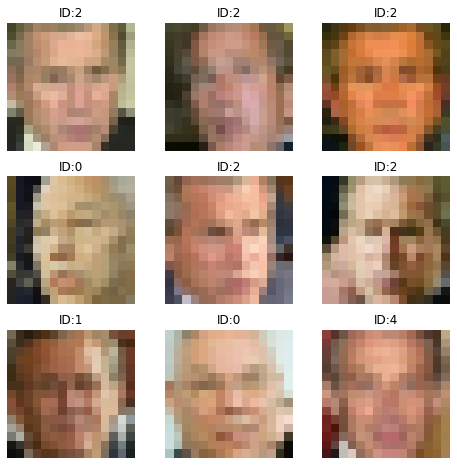

In [3]:
# train / test split
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import matplotlib.pyplot as plt

X_train, X_test, Y_train, Y_test = train_test_split(Z, Y, train_size=0.7, stratify=Y, random_state=666)
print("train size : " , X_train.shape[0] , " , test size : " , X_test.shape[0])

dataset_train = TensorDataset( Tensor(X_train), Tensor(Y_train) )
dataset_test = TensorDataset( Tensor(X_test), Tensor(Y_test) )

batch_size = 256

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size)

##############
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    train_features, train_labels = next(iter(train_loader))
    img = train_features[0].squeeze()
    img = img.numpy()
    img = img.transpose((1,2,0))
    figure.add_subplot(rows, cols, i)
    plt.title('ID:' + str(int(train_labels[0])))
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

# **Helper Functions:**

In [4]:
import torchvision
from numpy.core.numeric import tensordot
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
import matplotlib.pyplot as plt
import umap
import umap.plot
import random

device = torch.device("cuda")
num_epochs = 150

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, sz, 3, 1)
        self.conv2 = nn.Conv2d(sz, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(1600, 512)
        self.fc2 = nn.Linear(512, 256)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.relu()
        x = F.normalize(x)

        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.dropout1(x)

        x = self.fc1(x)
        x = x.relu()
        x = self.fc2(x)
        x = x.tanh()

        return x


def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    l=0
    i=0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        i=i+1
        optimizer.zero_grad()
        embeddings = model(data)
        loss = loss_func(embeddings, labels)
        l=l+loss
        loss.backward()
        optimizer.step()
    avg_loss = l/i
    print("Train : avg_loss = {}".format(avg_loss))
    return avg_loss


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator , test_loader , mining_func , loss_func):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    l=0
    j=0
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, train_embeddings, test_labels, train_labels, False
    )
    test_acc=accuracies["precision_at_1"]
    for batch_idx, (data, labels) in enumerate(test_loader):
        data, labels = data.to(device), labels.to(device)
        embeddings = model(data)
        
        loss = loss_func(embeddings, labels)
        l=l+loss
        j=j+1

    avg_loss=l/j

    print('Test : avg_loss = {}'.format (l))
    print('Test : acc = {}'.format (test_acc))

    return avg_loss , test_acc 

def get_sub_data_embed(dataset , model , num_sel):
  g = get_all_embeddings(dataset,model)
  embeddings = (g[0]).cpu()
  labels = (g[1].squeeze()).cpu()
  label_list = labels.unique()
  r = random.choices(label_list , k = num_sel)
  emd = np.empty((1,256))
  lab = np.empty((1,))

  for i in range(num_sel):
    j = np.where(labels==r[i])
    u = embeddings[j]
    v = labels[j]
    emd = np.concatenate((emd,u) , axis =0)
    lab = np.concatenate((lab,v) , axis=0)

  return emd , lab

def plot_graph(train_loss , test_loss , test_acc, title):
  figure = plt.figure()
  plt.subplot(2,1,1)
  plt.plot(list_to_cpu(train_loss) , label='Train Loss')
  plt.plot(list_to_cpu(test_loss) , label='Test Loss')
  plt.title('Distance Metric : ' + str(title))
  plt.ylabel('Loss')
  plt.legend(loc="upper right")

  plt.subplot(2,1,2)
  plt.plot(test_acc, label='Test Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy %')
  plt.legend(loc="upper left")

  plt.show()

def list_to_cpu(l):
  f=np.zeros((len(l),))
  for i in range(len(l)):
    f[i,] = l[i].cpu()
  return f


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def KNN_on_embeddings(dataset_train , dataset_test , model , K=5):
  train_data = get_all_embeddings(dataset_train , model)
  test_data = get_all_embeddings(dataset_test, model)
  embed_train = (train_data[0]).cpu()
  embed_test = (test_data[0]).cpu()
  label_train = (train_data[1].squeeze()).cpu()
  label_test = (test_data[1].squeeze()).cpu()

  knn = KNeighborsClassifier(n_neighbors = K)
  knn.fit(embed_train, label_train)

  label_pred = knn.predict(embed_test)
  print('')
  print("Test Acc : ", accuracy_score(label_test, label_pred)*100)

print(Net())

from torchsummary import summary


Net(
  (conv1): Conv2d(3, 15, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(15, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
)


In [7]:
from torchinfo import summary
summary(Net(), input_size=(batch_size, 3,15, 15))

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [256, 256]                --
├─Conv2d: 1-1                            [256, 15, 13, 13]         420
├─Conv2d: 1-2                            [256, 64, 11, 11]         8,704
├─Dropout2d: 1-3                         [256, 1600]               --
├─Linear: 1-4                            [256, 512]                819,712
├─Linear: 1-5                            [256, 256]                131,328
Total params: 960,164
Trainable params: 960,164
Non-trainable params: 0
Total mult-adds (M): 531.25
Input size (MB): 0.69
Forward/backward pass size (MB): 22.62
Params size (MB): 3.84
Estimated Total Size (MB): 27.16

# **Cosine Similarity without Mining**

In [32]:
device='cpu'
num_epochs=5
model_cosine = Net().to(device)

optimizer = optim.Adam(model_cosine.parameters(), lr=0.01)

### pytorch-metric-learning stuff ###
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard"
)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###

test_acc_cosine=[]
test_loss_cosine=[]
train_loss_cosine=[]
for epoch in range(1, num_epochs + 1):
    print("Epoch : {}".format(epoch))

    train_loss=train(model_cosine, loss_func, mining_func, device, train_loader, optimizer, epoch)
    test_loss , test_acc = test(dataset_train, dataset_test, model_cosine, accuracy_calculator, test_loader , mining_func , loss_func)

    test_loss_cosine.append(test_loss)
    test_acc_cosine.append(test_acc)
    train_loss_cosine.append(train_loss)

    print("******************************************")

Epoch : 1


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train : avg_loss = 0.19663028419017792


100%|██████████| 11/11 [00:00<00:00, 32.27it/s]


Test : avg_loss = 0.3982005715370178
Test : acc = 0.631578947368421
******************************************
Epoch : 2
Train : avg_loss = 0.1988002061843872


100%|██████████| 11/11 [00:00<00:00, 32.88it/s]


Test : avg_loss = 0.3983905613422394
Test : acc = 0.543859649122807
******************************************
Epoch : 3
Train : avg_loss = 0.19781313836574554


100%|██████████| 11/11 [00:00<00:00, 32.20it/s]


Test : avg_loss = 0.3992809057235718
Test : acc = 0.4327485380116959
******************************************
Epoch : 4
Train : avg_loss = 0.19990308582782745


100%|██████████| 11/11 [00:00<00:00, 31.23it/s]


Test : avg_loss = 0.39947307109832764
Test : acc = 0.4269005847953216
******************************************
Epoch : 5
Train : avg_loss = 0.19984889030456543


100%|██████████| 11/11 [00:00<00:00, 32.12it/s]


Test : avg_loss = 0.39987707138061523
Test : acc = 0.4444444444444444
******************************************


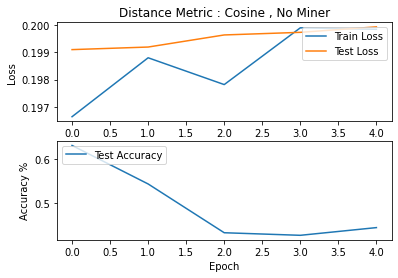

Max Test Acc = 0.631578947368421


In [33]:
plot_graph(train_loss_cosine , test_loss_cosine , test_acc_cosine , 'Cosine , No Miner')
print('Max Test Acc = {}' .format(np.max(test_acc_cosine)))

In [10]:
data_test,target_test=get_sub_data_embed(dataset_test , model_cosine , 5)
data_test = np.float32(data_test/(np.max(data_test)-np.min(data_test)))
data_train,target_train=get_sub_data_embed(dataset_train , model_cosine , 5)
data_train = np.float32(data_train/(np.max(data_train)-np.min(data_train)))

100%|██████████| 25/25 [00:01<00:00, 18.45it/s]


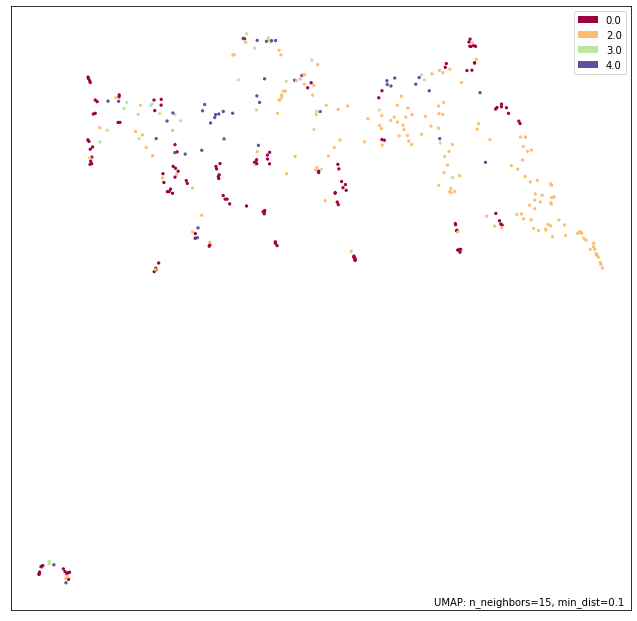

In [11]:
import umap
import umap.plot
mapper = umap.UMAP().fit(data_test)
umap.plot.points(mapper, labels=target_test)

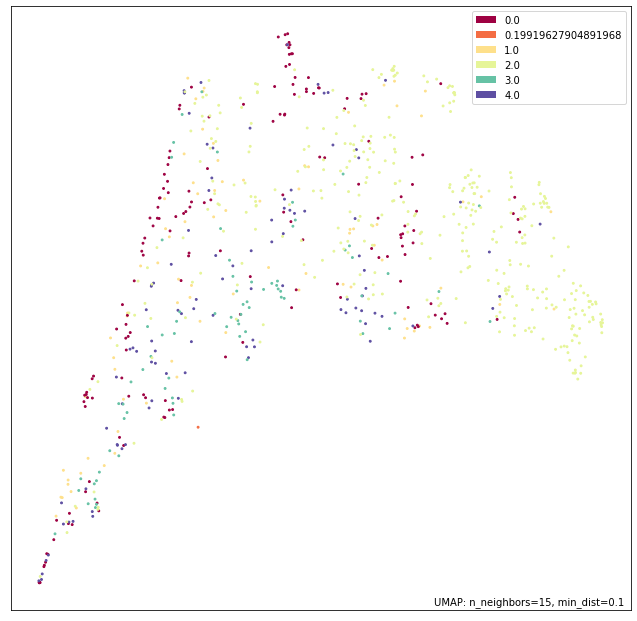

In [12]:
mapper = umap.UMAP().fit(data_train)
umap.plot.points(mapper, labels=target_train)

In [31]:
# KNN :
print("Test Acc without KNN :{} ".format(test_acc_cosine[0]))
KNN_on_embeddings(dataset_train , dataset_test , model_cosine , K=5)

Test Acc without KNN :0.543859649122807 


100%|██████████| 11/11 [00:00<00:00, 35.16it/s]



Test Acc :  57.01754385964912


# **Euclidean Distance without Mining**

In [23]:
device='cpu'
num_epochs = 5
model_Lp = Net().to(device)
optimizer = optim.Adam(model_Lp.parameters(), lr=0.01)

### pytorch-metric-learning stuff ###
distance = distances.LpDistance()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard"
)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###

test_acc_Lp=[]
test_loss_Lp=[]
train_loss_Lp=[]
for epoch in range(1, num_epochs + 1):
    print("Epoch : {}".format(epoch))

    train_loss=train(model_Lp, loss_func, mining_func, device, train_loader, optimizer, epoch)
    test_loss , test_acc = test(dataset_train, dataset_test, model_Lp, accuracy_calculator, test_loader , mining_func , loss_func)

    test_loss_Lp.append(test_loss)
    test_acc_Lp.append(test_acc)
    train_loss_Lp.append(train_loss)

    print("******************************************")

Epoch : 1


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train : avg_loss = 0.1977802813053131


100%|██████████| 11/11 [00:00<00:00, 34.37it/s]


Test : avg_loss = 0.3406071662902832
Test : acc = 0.6345029239766082
******************************************
Epoch : 2
Train : avg_loss = 0.1901579052209854


100%|██████████| 11/11 [00:00<00:00, 35.01it/s]


Test : avg_loss = 0.3391180634498596
Test : acc = 0.6549707602339181
******************************************
Epoch : 3
Train : avg_loss = 0.19215279817581177


100%|██████████| 11/11 [00:00<00:00, 34.26it/s]


Test : avg_loss = 0.34228771924972534
Test : acc = 0.6549707602339181
******************************************
Epoch : 4
Train : avg_loss = 0.1973605751991272


100%|██████████| 11/11 [00:00<00:00, 36.95it/s]


Test : avg_loss = 0.3293702006340027
Test : acc = 0.6695906432748538
******************************************
Epoch : 5
Train : avg_loss = 0.17088890075683594


100%|██████████| 11/11 [00:00<00:00, 33.65it/s]


Test : avg_loss = 0.35564497113227844
Test : acc = 0.6549707602339181
******************************************


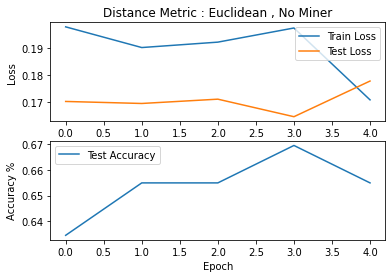

Max Test Acc = 0.6695906432748538


In [24]:
plot_graph(train_loss_Lp , test_loss_Lp , test_acc_Lp , 'Euclidean , No Miner')
print('Max Test Acc = {}' .format(np.max(test_acc_Lp)))

In [25]:
data_test,target_test=get_sub_data_embed(dataset_test , model_Lp , 5)
data_test = np.float32(data_test/(np.max(data_test)-np.min(data_test)))
data_train,target_train=get_sub_data_embed(dataset_train , model_Lp , 5)
data_train = np.float32(data_train/(np.max(data_train)-np.min(data_train)))

  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 25/25 [00:00<00:00, 51.60it/s]


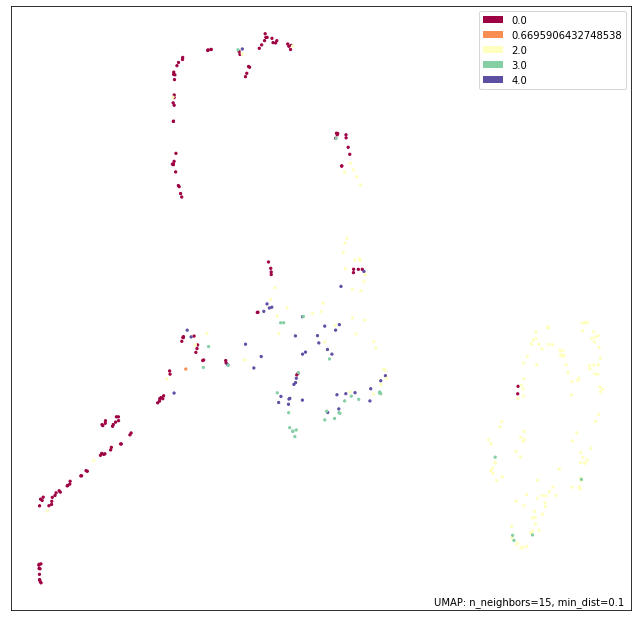

In [26]:
import umap
import umap.plot
mapper = umap.UMAP().fit(data_test)
umap.plot.points(mapper, labels=target_test)

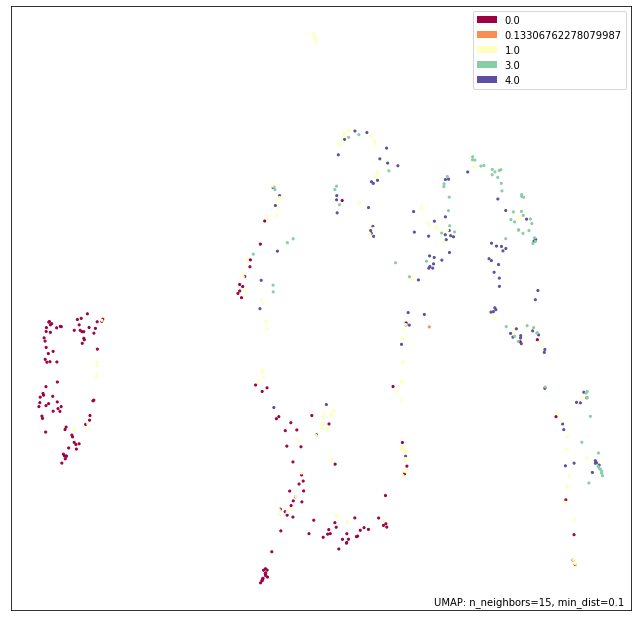

In [27]:
mapper = umap.UMAP().fit(data_train)
umap.plot.points(mapper, labels=target_train)

In [28]:
# KNN :
print("Test Acc without KNN :{} ".format(test_acc_Lp[4]))
KNN_on_embeddings(dataset_train , dataset_test , model_Lp , K=5)

Test Acc without KNN :0.6549707602339181 


  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 11/11 [00:00<00:00, 34.25it/s]



Test Acc :  70.76023391812866


# **EXAMPLE MINER**

In [5]:
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    l=0
    i=0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        i=i+1
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        l=l+loss
        loss.backward()
        optimizer.step()
    avg_loss = l/i
    print("Train : avg_loss = {}".format(avg_loss))
    return avg_loss


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator , test_loader , mining_func , loss_func):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    l=0
    j=0
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, train_embeddings, test_labels, train_labels, False
    )
    test_acc=accuracies["precision_at_1"]
    for batch_idx, (data, labels) in enumerate(test_loader):
        data, labels = data.to(device), labels.to(device)
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        l=l+loss
        j=j+1

    avg_loss=l/j

    print('Test : avg_loss = {}'.format (l))
    print('Test : acc = {}'.format (test_acc))

    return avg_loss , test_acc 


# **Cosine Similarity with Mining**

In [7]:
device='cpu'
num_epochs=150
model_cosine = Net().to(device)

optimizer = optim.Adam(model_cosine.parameters(), lr=0.01)

### pytorch-metric-learning stuff ###
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard"
)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###

test_acc_cosine=[]
test_loss_cosine=[]
train_loss_cosine=[]
for epoch in range(1, num_epochs + 1):
    print("Epoch : {}".format(epoch))

    train_loss=train(model_cosine, loss_func, mining_func, device, train_loader, optimizer, epoch)
    test_loss , test_acc = test(dataset_train, dataset_test, model_cosine, accuracy_calculator, test_loader , mining_func , loss_func)

    test_loss_cosine.append(test_loss)
    test_acc_cosine.append(test_acc)
    train_loss_cosine.append(train_loss)

    print("******************************************")

Epoch : 1


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train : avg_loss = 0.1801830530166626


100%|██████████| 11/11 [00:00<00:00, 47.68it/s]


Test : avg_loss = 0.3945992887020111
Test : acc = 0.43567251461988304
******************************************
Epoch : 2
Train : avg_loss = 0.19245827198028564


100%|██████████| 11/11 [00:00<00:00, 45.16it/s]


Test : avg_loss = 0.3655714690685272
Test : acc = 0.3538011695906433
******************************************
Epoch : 3
Train : avg_loss = 0.17317858338356018


100%|██████████| 11/11 [00:00<00:00, 46.01it/s]


Test : avg_loss = 0.28202420473098755
Test : acc = 0.3538011695906433
******************************************
Epoch : 4
Train : avg_loss = 0.14391228556632996


100%|██████████| 11/11 [00:00<00:00, 41.23it/s]


Test : avg_loss = 0.24513456225395203
Test : acc = 0.3538011695906433
******************************************
Epoch : 5
Train : avg_loss = 0.12016363441944122


100%|██████████| 11/11 [00:00<00:00, 44.61it/s]


Test : avg_loss = 0.2250334918498993
Test : acc = 0.30701754385964913
******************************************
Epoch : 6
Train : avg_loss = 0.10928318649530411


100%|██████████| 11/11 [00:00<00:00, 46.05it/s]


Test : avg_loss = 0.231519877910614
Test : acc = 0.3567251461988304
******************************************
Epoch : 7
Train : avg_loss = 0.11267156898975372


100%|██████████| 11/11 [00:00<00:00, 46.50it/s]


Test : avg_loss = 0.2152634561061859
Test : acc = 0.3362573099415205
******************************************
Epoch : 8
Train : avg_loss = 0.11057652533054352


100%|██████████| 11/11 [00:00<00:00, 43.11it/s]


Test : avg_loss = 0.22258490324020386
Test : acc = 0.3333333333333333
******************************************
Epoch : 9
Train : avg_loss = 0.10860171169042587


100%|██████████| 11/11 [00:00<00:00, 43.26it/s]


Test : avg_loss = 0.21901899576187134
Test : acc = 0.34210526315789475
******************************************
Epoch : 10
Train : avg_loss = 0.11171554028987885


100%|██████████| 11/11 [00:00<00:00, 42.20it/s]


Test : avg_loss = 0.2177855372428894
Test : acc = 0.34502923976608185
******************************************
Epoch : 11
Train : avg_loss = 0.1078316941857338


100%|██████████| 11/11 [00:00<00:00, 39.95it/s]


Test : avg_loss = 0.23141753673553467
Test : acc = 0.3830409356725146
******************************************
Epoch : 12
Train : avg_loss = 0.11042287945747375


100%|██████████| 11/11 [00:00<00:00, 41.19it/s]


Test : avg_loss = 0.2163195013999939
Test : acc = 0.4152046783625731
******************************************
Epoch : 13
Train : avg_loss = 0.10654780268669128


100%|██████████| 11/11 [00:00<00:00, 37.81it/s]


Test : avg_loss = 0.21633197367191315
Test : acc = 0.41228070175438597
******************************************
Epoch : 14
Train : avg_loss = 0.11037951707839966


100%|██████████| 11/11 [00:00<00:00, 25.97it/s]


Test : avg_loss = 0.21399442851543427
Test : acc = 0.4415204678362573
******************************************
Epoch : 15
Train : avg_loss = 0.1059444397687912


100%|██████████| 11/11 [00:00<00:00, 38.85it/s]


Test : avg_loss = 0.23075607419013977
Test : acc = 0.4269005847953216
******************************************
Epoch : 16
Train : avg_loss = 0.11186293512582779


100%|██████████| 11/11 [00:00<00:00, 39.42it/s]


Test : avg_loss = 0.21388806402683258
Test : acc = 0.4444444444444444
******************************************
Epoch : 17
Train : avg_loss = 0.11150573939085007


100%|██████████| 11/11 [00:00<00:00, 42.07it/s]


Test : avg_loss = 0.2219569981098175
Test : acc = 0.4853801169590643
******************************************
Epoch : 18
Train : avg_loss = 0.11404573917388916


100%|██████████| 11/11 [00:00<00:00, 36.13it/s]


Test : avg_loss = 0.21100884675979614
Test : acc = 0.4824561403508772
******************************************
Epoch : 19
Train : avg_loss = 0.10570698231458664


100%|██████████| 11/11 [00:00<00:00, 36.18it/s]


Test : avg_loss = 0.20607328414916992
Test : acc = 0.5087719298245614
******************************************
Epoch : 20
Train : avg_loss = 0.10975994914770126


100%|██████████| 11/11 [00:00<00:00, 37.40it/s]


Test : avg_loss = 0.20803380012512207
Test : acc = 0.5497076023391813
******************************************
Epoch : 21
Train : avg_loss = 0.10457762330770493


100%|██████████| 11/11 [00:00<00:00, 22.15it/s]


Test : avg_loss = 0.21003711223602295
Test : acc = 0.52046783625731
******************************************
Epoch : 22
Train : avg_loss = 0.10692638158798218


100%|██████████| 11/11 [00:00<00:00, 39.78it/s]


Test : avg_loss = 0.21115699410438538
Test : acc = 0.5233918128654971
******************************************
Epoch : 23
Train : avg_loss = 0.10517704486846924


100%|██████████| 11/11 [00:00<00:00, 37.31it/s]


Test : avg_loss = 0.2120898962020874
Test : acc = 0.5380116959064327
******************************************
Epoch : 24
Train : avg_loss = 0.10300324857234955


100%|██████████| 11/11 [00:00<00:00, 36.50it/s]


Test : avg_loss = 0.2130582183599472
Test : acc = 0.5380116959064327
******************************************
Epoch : 25
Train : avg_loss = 0.10413513332605362


100%|██████████| 11/11 [00:00<00:00, 34.92it/s]


Test : avg_loss = 0.21561652421951294
Test : acc = 0.5701754385964912
******************************************
Epoch : 26
Train : avg_loss = 0.10558569431304932


100%|██████████| 11/11 [00:00<00:00, 32.00it/s]


Test : avg_loss = 0.21981534361839294
Test : acc = 0.5058479532163743
******************************************
Epoch : 27
Train : avg_loss = 0.10945107042789459


100%|██████████| 11/11 [00:00<00:00, 36.97it/s]


Test : avg_loss = 0.20330974459648132
Test : acc = 0.5467836257309941
******************************************
Epoch : 28
Train : avg_loss = 0.10497798770666122


100%|██████████| 11/11 [00:00<00:00, 37.21it/s]


Test : avg_loss = 0.2073618471622467
Test : acc = 0.5877192982456141
******************************************
Epoch : 29
Train : avg_loss = 0.10863862931728363


100%|██████████| 11/11 [00:00<00:00, 34.91it/s]


Test : avg_loss = 0.20706039667129517
Test : acc = 0.5701754385964912
******************************************
Epoch : 30
Train : avg_loss = 0.10152031481266022


100%|██████████| 11/11 [00:00<00:00, 35.51it/s]


Test : avg_loss = 0.19145870208740234
Test : acc = 0.5760233918128655
******************************************
Epoch : 31
Train : avg_loss = 0.1022443026304245


100%|██████████| 11/11 [00:00<00:00, 34.79it/s]


Test : avg_loss = 0.20129087567329407
Test : acc = 0.6023391812865497
******************************************
Epoch : 32
Train : avg_loss = 0.10516296327114105


100%|██████████| 11/11 [00:00<00:00, 32.67it/s]


Test : avg_loss = 0.21219292283058167
Test : acc = 0.6111111111111112
******************************************
Epoch : 33
Train : avg_loss = 0.1010897308588028


100%|██████████| 11/11 [00:00<00:00, 33.42it/s]


Test : avg_loss = 0.18968364596366882
Test : acc = 0.6432748538011696
******************************************
Epoch : 34
Train : avg_loss = 0.09858671575784683


100%|██████████| 11/11 [00:00<00:00, 34.62it/s]


Test : avg_loss = 0.20088738203048706
Test : acc = 0.6491228070175439
******************************************
Epoch : 35
Train : avg_loss = 0.09954225271940231


100%|██████████| 11/11 [00:00<00:00, 33.74it/s]


Test : avg_loss = 0.1907164752483368
Test : acc = 0.6578947368421053
******************************************
Epoch : 36
Train : avg_loss = 0.10050251334905624


100%|██████████| 11/11 [00:00<00:00, 35.13it/s]


Test : avg_loss = 0.1942889541387558
Test : acc = 0.6081871345029239
******************************************
Epoch : 37
Train : avg_loss = 0.09718216955661774


100%|██████████| 11/11 [00:00<00:00, 31.52it/s]


Test : avg_loss = 0.19583328068256378
Test : acc = 0.6374269005847953
******************************************
Epoch : 38
Train : avg_loss = 0.10031402856111526


100%|██████████| 11/11 [00:00<00:00, 30.68it/s]


Test : avg_loss = 0.22309984266757965
Test : acc = 0.6695906432748538
******************************************
Epoch : 39
Train : avg_loss = 0.101297527551651


100%|██████████| 11/11 [00:00<00:00, 33.67it/s]


Test : avg_loss = 0.19597208499908447
Test : acc = 0.716374269005848
******************************************
Epoch : 40
Train : avg_loss = 0.09893060475587845


100%|██████████| 11/11 [00:00<00:00, 34.70it/s]


Test : avg_loss = 0.20286160707473755
Test : acc = 0.672514619883041
******************************************
Epoch : 41
Train : avg_loss = 0.10024109482765198


100%|██████████| 11/11 [00:00<00:00, 35.33it/s]


Test : avg_loss = 0.19926005601882935
Test : acc = 0.6608187134502924
******************************************
Epoch : 42
Train : avg_loss = 0.10056997090578079


100%|██████████| 11/11 [00:00<00:00, 35.28it/s]


Test : avg_loss = 0.19065207242965698
Test : acc = 0.6491228070175439
******************************************
Epoch : 43
Train : avg_loss = 0.09528951346874237


100%|██████████| 11/11 [00:00<00:00, 33.13it/s]


Test : avg_loss = 0.1831807792186737
Test : acc = 0.6871345029239766
******************************************
Epoch : 44
Train : avg_loss = 0.09460782259702682


100%|██████████| 11/11 [00:00<00:00, 34.67it/s]


Test : avg_loss = 0.18987497687339783
Test : acc = 0.6754385964912281
******************************************
Epoch : 45
Train : avg_loss = 0.09387314319610596


100%|██████████| 11/11 [00:00<00:00, 33.33it/s]


Test : avg_loss = 0.19158127903938293
Test : acc = 0.7280701754385965
******************************************
Epoch : 46
Train : avg_loss = 0.09984994679689407


100%|██████████| 11/11 [00:00<00:00, 32.05it/s]


Test : avg_loss = 0.19513624906539917
Test : acc = 0.7222222222222222
******************************************
Epoch : 47
Train : avg_loss = 0.09405706822872162


100%|██████████| 11/11 [00:00<00:00, 31.96it/s]


Test : avg_loss = 0.192559152841568
Test : acc = 0.7280701754385965
******************************************
Epoch : 48
Train : avg_loss = 0.10073743760585785


100%|██████████| 11/11 [00:00<00:00, 31.46it/s]


Test : avg_loss = 0.19624462723731995
Test : acc = 0.7046783625730995
******************************************
Epoch : 49
Train : avg_loss = 0.10006438195705414


100%|██████████| 11/11 [00:00<00:00, 30.41it/s]


Test : avg_loss = 0.18625286221504211
Test : acc = 0.695906432748538
******************************************
Epoch : 50
Train : avg_loss = 0.09754426777362823


100%|██████████| 11/11 [00:00<00:00, 31.05it/s]


Test : avg_loss = 0.19314727187156677
Test : acc = 0.7251461988304093
******************************************
Epoch : 51
Train : avg_loss = 0.09759971499443054


100%|██████████| 11/11 [00:00<00:00, 30.65it/s]


Test : avg_loss = 0.19020627439022064
Test : acc = 0.7426900584795322
******************************************
Epoch : 52
Train : avg_loss = 0.10208708047866821


100%|██████████| 11/11 [00:00<00:00, 31.47it/s]


Test : avg_loss = 0.19173699617385864
Test : acc = 0.7631578947368421
******************************************
Epoch : 53
Train : avg_loss = 0.09739746153354645


100%|██████████| 11/11 [00:00<00:00, 29.59it/s]


Test : avg_loss = 0.20042426884174347
Test : acc = 0.7514619883040936
******************************************
Epoch : 54
Train : avg_loss = 0.0910138264298439


100%|██████████| 11/11 [00:00<00:00, 29.09it/s]


Test : avg_loss = 0.19585758447647095
Test : acc = 0.7690058479532164
******************************************
Epoch : 55
Train : avg_loss = 0.09613175690174103


100%|██████████| 11/11 [00:00<00:00, 29.70it/s]


Test : avg_loss = 0.20120514929294586
Test : acc = 0.7719298245614035
******************************************
Epoch : 56
Train : avg_loss = 0.09327437728643417


100%|██████████| 11/11 [00:00<00:00, 29.61it/s]


Test : avg_loss = 0.19772998988628387
Test : acc = 0.7456140350877193
******************************************
Epoch : 57
Train : avg_loss = 0.09504224359989166


100%|██████████| 11/11 [00:00<00:00, 28.91it/s]


Test : avg_loss = 0.18556112051010132
Test : acc = 0.7339181286549707
******************************************
Epoch : 58
Train : avg_loss = 0.09416838735342026


100%|██████████| 11/11 [00:00<00:00, 29.86it/s]


Test : avg_loss = 0.19526150822639465
Test : acc = 0.7397660818713451
******************************************
Epoch : 59
Train : avg_loss = 0.09242774546146393


100%|██████████| 11/11 [00:00<00:00, 28.58it/s]


Test : avg_loss = 0.1925307959318161
Test : acc = 0.7514619883040936
******************************************
Epoch : 60
Train : avg_loss = 0.09475426375865936


100%|██████████| 11/11 [00:00<00:00, 28.60it/s]


Test : avg_loss = 0.2001357227563858
Test : acc = 0.7865497076023392
******************************************
Epoch : 61
Train : avg_loss = 0.09448254108428955


100%|██████████| 11/11 [00:00<00:00, 28.42it/s]


Test : avg_loss = 0.1958812177181244
Test : acc = 0.7543859649122807
******************************************
Epoch : 62
Train : avg_loss = 0.09627770632505417


100%|██████████| 11/11 [00:00<00:00, 27.59it/s]


Test : avg_loss = 0.19414249062538147
Test : acc = 0.7865497076023392
******************************************
Epoch : 63
Train : avg_loss = 0.09122460335493088


100%|██████████| 11/11 [00:00<00:00, 27.97it/s]


Test : avg_loss = 0.20533329248428345
Test : acc = 0.7748538011695907
******************************************
Epoch : 64
Train : avg_loss = 0.0977148488163948


100%|██████████| 11/11 [00:00<00:00, 27.72it/s]


Test : avg_loss = 0.1851712167263031
Test : acc = 0.7777777777777778
******************************************
Epoch : 65
Train : avg_loss = 0.09675924479961395


100%|██████████| 11/11 [00:00<00:00, 28.59it/s]


Test : avg_loss = 0.1923629343509674
Test : acc = 0.7923976608187134
******************************************
Epoch : 66
Train : avg_loss = 0.08811257034540176


100%|██████████| 11/11 [00:00<00:00, 26.74it/s]


Test : avg_loss = 0.19490642845630646
Test : acc = 0.7982456140350878
******************************************
Epoch : 67
Train : avg_loss = 0.09264189004898071


100%|██████████| 11/11 [00:00<00:00, 28.15it/s]


Test : avg_loss = 0.1985955536365509
Test : acc = 0.783625730994152
******************************************
Epoch : 68
Train : avg_loss = 0.09285572916269302


100%|██████████| 11/11 [00:00<00:00, 26.59it/s]


Test : avg_loss = 0.19133669137954712
Test : acc = 0.783625730994152
******************************************
Epoch : 69
Train : avg_loss = 0.09304997324943542


100%|██████████| 11/11 [00:00<00:00, 27.79it/s]


Test : avg_loss = 0.20286825299263
Test : acc = 0.7894736842105263
******************************************
Epoch : 70
Train : avg_loss = 0.0989847332239151


100%|██████████| 11/11 [00:00<00:00, 28.60it/s]


Test : avg_loss = 0.20685118436813354
Test : acc = 0.8011695906432749
******************************************
Epoch : 71
Train : avg_loss = 0.09409783780574799


100%|██████████| 11/11 [00:00<00:00, 27.06it/s]


Test : avg_loss = 0.1934073567390442
Test : acc = 0.7953216374269005
******************************************
Epoch : 72
Train : avg_loss = 0.10694079101085663


100%|██████████| 11/11 [00:00<00:00, 26.84it/s]


Test : avg_loss = 0.19574685394763947
Test : acc = 0.804093567251462
******************************************
Epoch : 73
Train : avg_loss = 0.10305047780275345


100%|██████████| 11/11 [00:00<00:00, 28.52it/s]


Test : avg_loss = 0.19561055302619934
Test : acc = 0.7982456140350878
******************************************
Epoch : 74
Train : avg_loss = 0.09892921149730682


100%|██████████| 11/11 [00:00<00:00, 28.10it/s]


Test : avg_loss = 0.19098110496997833
Test : acc = 0.7923976608187134
******************************************
Epoch : 75
Train : avg_loss = 0.09111647307872772


100%|██████████| 11/11 [00:00<00:00, 25.42it/s]


Test : avg_loss = 0.1908724009990692
Test : acc = 0.7660818713450293
******************************************
Epoch : 76
Train : avg_loss = 0.09084475040435791


100%|██████████| 11/11 [00:00<00:00, 25.71it/s]


Test : avg_loss = 0.1918998658657074
Test : acc = 0.7894736842105263
******************************************
Epoch : 77
Train : avg_loss = 0.09660536050796509


100%|██████████| 11/11 [00:00<00:00, 26.64it/s]


Test : avg_loss = 0.20187869668006897
Test : acc = 0.8011695906432749
******************************************
Epoch : 78
Train : avg_loss = 0.08613649010658264


100%|██████████| 11/11 [00:00<00:00, 26.78it/s]


Test : avg_loss = 0.2158530354499817
Test : acc = 0.783625730994152
******************************************
Epoch : 79
Train : avg_loss = 0.1021820604801178


100%|██████████| 11/11 [00:00<00:00, 26.76it/s]


Test : avg_loss = 0.19947850704193115
Test : acc = 0.7865497076023392
******************************************
Epoch : 80
Train : avg_loss = 0.09022720158100128


100%|██████████| 11/11 [00:00<00:00, 27.37it/s]


Test : avg_loss = 0.2236402928829193
Test : acc = 0.8011695906432749
******************************************
Epoch : 81
Train : avg_loss = 0.09362690895795822


100%|██████████| 11/11 [00:00<00:00, 25.11it/s]


Test : avg_loss = 0.21032005548477173
Test : acc = 0.7777777777777778
******************************************
Epoch : 82
Train : avg_loss = 0.09832954406738281


100%|██████████| 11/11 [00:00<00:00, 25.59it/s]


Test : avg_loss = 0.2058190405368805
Test : acc = 0.7777777777777778
******************************************
Epoch : 83
Train : avg_loss = 0.10190384089946747


100%|██████████| 11/11 [00:00<00:00, 26.23it/s]


Test : avg_loss = 0.1905304193496704
Test : acc = 0.8099415204678363
******************************************
Epoch : 84
Train : avg_loss = 0.09284456819295883


100%|██████████| 11/11 [00:00<00:00, 24.82it/s]


Test : avg_loss = 0.19346097111701965
Test : acc = 0.827485380116959
******************************************
Epoch : 85
Train : avg_loss = 0.09079406410455704


100%|██████████| 11/11 [00:00<00:00, 25.24it/s]


Test : avg_loss = 0.19402264058589935
Test : acc = 0.8070175438596491
******************************************
Epoch : 86
Train : avg_loss = 0.09256981313228607


100%|██████████| 11/11 [00:00<00:00, 12.97it/s]


Test : avg_loss = 0.21074283123016357
Test : acc = 0.8245614035087719
******************************************
Epoch : 87
Train : avg_loss = 0.08814653754234314


100%|██████████| 11/11 [00:00<00:00, 13.01it/s]


Test : avg_loss = 0.20545117557048798
Test : acc = 0.827485380116959
******************************************
Epoch : 88
Train : avg_loss = 0.09076748788356781


100%|██████████| 11/11 [00:00<00:00, 25.14it/s]


Test : avg_loss = 0.2072749137878418
Test : acc = 0.804093567251462
******************************************
Epoch : 89
Train : avg_loss = 0.0970047116279602


100%|██████████| 11/11 [00:00<00:00, 24.72it/s]


Test : avg_loss = 0.20613616704940796
Test : acc = 0.7807017543859649
******************************************
Epoch : 90
Train : avg_loss = 0.09105417132377625


100%|██████████| 11/11 [00:00<00:00, 25.00it/s]


Test : avg_loss = 0.23303887248039246
Test : acc = 0.804093567251462
******************************************
Epoch : 91
Train : avg_loss = 0.09363023936748505


100%|██████████| 11/11 [00:00<00:00, 23.57it/s]


Test : avg_loss = 0.21585196256637573
Test : acc = 0.804093567251462
******************************************
Epoch : 92
Train : avg_loss = 0.08886018395423889


100%|██████████| 11/11 [00:00<00:00, 24.04it/s]


Test : avg_loss = 0.20949473977088928
Test : acc = 0.8216374269005848
******************************************
Epoch : 93
Train : avg_loss = 0.09225192666053772


100%|██████████| 11/11 [00:00<00:00, 15.26it/s]


Test : avg_loss = 0.19471272826194763
Test : acc = 0.8216374269005848
******************************************
Epoch : 94
Train : avg_loss = 0.09099554270505905


100%|██████████| 11/11 [00:00<00:00, 24.05it/s]


Test : avg_loss = 0.19057223200798035
Test : acc = 0.827485380116959
******************************************
Epoch : 95
Train : avg_loss = 0.09349197894334793


100%|██████████| 11/11 [00:00<00:00, 24.76it/s]


Test : avg_loss = 0.19759008288383484
Test : acc = 0.8187134502923976
******************************************
Epoch : 96
Train : avg_loss = 0.09902019798755646


100%|██████████| 11/11 [00:00<00:00, 23.50it/s]


Test : avg_loss = 0.18612922728061676
Test : acc = 0.847953216374269
******************************************
Epoch : 97
Train : avg_loss = 0.09185485541820526


100%|██████████| 11/11 [00:00<00:00, 24.22it/s]


Test : avg_loss = 0.19289204478263855
Test : acc = 0.7953216374269005
******************************************
Epoch : 98
Train : avg_loss = 0.10035423189401627


100%|██████████| 11/11 [00:00<00:00, 23.22it/s]


Test : avg_loss = 0.19398930668830872
Test : acc = 0.8304093567251462
******************************************
Epoch : 99
Train : avg_loss = 0.08433537185192108


100%|██████████| 11/11 [00:00<00:00, 23.85it/s]


Test : avg_loss = 0.19441774487495422
Test : acc = 0.847953216374269
******************************************
Epoch : 100
Train : avg_loss = 0.08828489482402802


100%|██████████| 11/11 [00:00<00:00, 24.38it/s]


Test : avg_loss = 0.18619008362293243
Test : acc = 0.8596491228070176
******************************************
Epoch : 101
Train : avg_loss = 0.09665217995643616


100%|██████████| 11/11 [00:00<00:00, 23.03it/s]


Test : avg_loss = 0.19348973035812378
Test : acc = 0.8567251461988304
******************************************
Epoch : 102
Train : avg_loss = 0.07323919236660004


100%|██████████| 11/11 [00:00<00:00, 22.96it/s]


Test : avg_loss = 0.19232787191867828
Test : acc = 0.8713450292397661
******************************************
Epoch : 103
Train : avg_loss = 0.09150931984186172


100%|██████████| 11/11 [00:00<00:00, 23.12it/s]


Test : avg_loss = 0.1958940029144287
Test : acc = 0.8625730994152047
******************************************
Epoch : 104
Train : avg_loss = 0.08674357086420059


100%|██████████| 11/11 [00:00<00:00, 22.73it/s]


Test : avg_loss = 0.1934405416250229
Test : acc = 0.8742690058479532
******************************************
Epoch : 105
Train : avg_loss = 0.08084642142057419


100%|██████████| 11/11 [00:00<00:00, 21.73it/s]


Test : avg_loss = 0.19745507836341858
Test : acc = 0.8567251461988304
******************************************
Epoch : 106
Train : avg_loss = 0.08033681660890579


100%|██████████| 11/11 [00:00<00:00, 21.21it/s]


Test : avg_loss = 0.20403525233268738
Test : acc = 0.8538011695906432
******************************************
Epoch : 107
Train : avg_loss = 0.08756240457296371


100%|██████████| 11/11 [00:00<00:00, 21.15it/s]


Test : avg_loss = 0.20873448252677917
Test : acc = 0.827485380116959
******************************************
Epoch : 108
Train : avg_loss = 0.09840936213731766


100%|██████████| 11/11 [00:00<00:00, 22.61it/s]


Test : avg_loss = 0.1968693733215332
Test : acc = 0.8508771929824561
******************************************
Epoch : 109
Train : avg_loss = 0.08429385721683502


100%|██████████| 11/11 [00:00<00:00, 23.02it/s]


Test : avg_loss = 0.19938284158706665
Test : acc = 0.8538011695906432
******************************************
Epoch : 110
Train : avg_loss = 0.07987421005964279


100%|██████████| 11/11 [00:00<00:00, 22.53it/s]


Test : avg_loss = 0.18752583861351013
Test : acc = 0.8567251461988304
******************************************
Epoch : 111
Train : avg_loss = 0.08258271962404251


100%|██████████| 11/11 [00:00<00:00, 21.51it/s]


Test : avg_loss = 0.19802045822143555
Test : acc = 0.8421052631578947
******************************************
Epoch : 112
Train : avg_loss = 0.10091014951467514


100%|██████████| 11/11 [00:00<00:00, 22.02it/s]


Test : avg_loss = 0.18214382231235504
Test : acc = 0.7865497076023392
******************************************
Epoch : 113
Train : avg_loss = 0.09606778621673584


100%|██████████| 11/11 [00:00<00:00, 21.87it/s]


Test : avg_loss = 0.19192412495613098
Test : acc = 0.7719298245614035
******************************************
Epoch : 114
Train : avg_loss = 0.09678515791893005


100%|██████████| 11/11 [00:00<00:00, 21.97it/s]


Test : avg_loss = 0.1829754114151001
Test : acc = 0.7807017543859649
******************************************
Epoch : 115
Train : avg_loss = 0.09647585451602936


100%|██████████| 11/11 [00:00<00:00, 21.20it/s]


Test : avg_loss = 0.19581085443496704
Test : acc = 0.804093567251462
******************************************
Epoch : 116
Train : avg_loss = 0.10539667308330536


100%|██████████| 11/11 [00:00<00:00, 22.63it/s]


Test : avg_loss = 0.17353281378746033
Test : acc = 0.8157894736842105
******************************************
Epoch : 117
Train : avg_loss = 0.09842272102832794


100%|██████████| 11/11 [00:00<00:00, 20.47it/s]


Test : avg_loss = 0.20129048824310303
Test : acc = 0.8567251461988304
******************************************
Epoch : 118
Train : avg_loss = 0.08750656992197037


100%|██████████| 11/11 [00:00<00:00, 20.86it/s]


Test : avg_loss = 0.21062827110290527
Test : acc = 0.8654970760233918
******************************************
Epoch : 119
Train : avg_loss = 0.08307266980409622


100%|██████████| 11/11 [00:00<00:00, 21.24it/s]


Test : avg_loss = 0.20634886622428894
Test : acc = 0.8567251461988304
******************************************
Epoch : 120
Train : avg_loss = 0.09731902182102203


100%|██████████| 11/11 [00:00<00:00, 20.05it/s]


Test : avg_loss = 0.19614796340465546
Test : acc = 0.8596491228070176
******************************************
Epoch : 121
Train : avg_loss = 0.07827550917863846


100%|██████████| 11/11 [00:00<00:00, 20.24it/s]


Test : avg_loss = 0.17115509510040283
Test : acc = 0.8742690058479532
******************************************
Epoch : 122
Train : avg_loss = 0.09295479208230972


100%|██████████| 11/11 [00:00<00:00, 21.00it/s]


Test : avg_loss = 0.19333456456661224
Test : acc = 0.868421052631579
******************************************
Epoch : 123
Train : avg_loss = 0.08912430703639984


100%|██████████| 11/11 [00:00<00:00, 20.65it/s]


Test : avg_loss = 0.20225536823272705
Test : acc = 0.868421052631579
******************************************
Epoch : 124
Train : avg_loss = 0.07677571475505829


100%|██████████| 11/11 [00:00<00:00, 19.71it/s]


Test : avg_loss = 0.20341823995113373
Test : acc = 0.8801169590643275
******************************************
Epoch : 125
Train : avg_loss = 0.09669021517038345


100%|██████████| 11/11 [00:00<00:00, 20.71it/s]


Test : avg_loss = 0.2056390941143036
Test : acc = 0.8742690058479532
******************************************
Epoch : 126
Train : avg_loss = 0.08616402745246887


100%|██████████| 11/11 [00:00<00:00, 20.40it/s]


Test : avg_loss = 0.19728969037532806
Test : acc = 0.8567251461988304
******************************************
Epoch : 127
Train : avg_loss = 0.08599692583084106


100%|██████████| 11/11 [00:00<00:00, 20.28it/s]


Test : avg_loss = 0.20422479510307312
Test : acc = 0.8742690058479532
******************************************
Epoch : 128
Train : avg_loss = 0.0937032550573349


100%|██████████| 11/11 [00:00<00:00, 20.25it/s]


Test : avg_loss = 0.1908245086669922
Test : acc = 0.8918128654970761
******************************************
Epoch : 129
Train : avg_loss = 0.09088489413261414


100%|██████████| 11/11 [00:00<00:00, 21.10it/s]


Test : avg_loss = 0.19440500438213348
Test : acc = 0.8918128654970761
******************************************
Epoch : 130
Train : avg_loss = 0.0918673574924469


100%|██████████| 11/11 [00:00<00:00, 20.08it/s]


Test : avg_loss = 0.2039458155632019
Test : acc = 0.8918128654970761
******************************************
Epoch : 131
Train : avg_loss = 0.07816044986248016


100%|██████████| 11/11 [00:00<00:00, 19.27it/s]


Test : avg_loss = 0.22352740168571472
Test : acc = 0.8976608187134503
******************************************
Epoch : 132
Train : avg_loss = 0.09338054805994034


100%|██████████| 11/11 [00:00<00:00, 20.69it/s]


Test : avg_loss = 0.2109980583190918
Test : acc = 0.8888888888888888
******************************************
Epoch : 133
Train : avg_loss = 0.09581737220287323


100%|██████████| 11/11 [00:00<00:00, 19.02it/s]


Test : avg_loss = 0.20021790266036987
Test : acc = 0.8596491228070176
******************************************
Epoch : 134
Train : avg_loss = 0.08890722692012787


100%|██████████| 11/11 [00:00<00:00, 19.12it/s]


Test : avg_loss = 0.2119567096233368
Test : acc = 0.8771929824561403
******************************************
Epoch : 135
Train : avg_loss = 0.08462093770503998


100%|██████████| 11/11 [00:00<00:00, 20.26it/s]


Test : avg_loss = 0.18913133442401886
Test : acc = 0.8771929824561403
******************************************
Epoch : 136
Train : avg_loss = 0.0889841765165329


100%|██████████| 11/11 [00:00<00:00, 19.87it/s]


Test : avg_loss = 0.18625962734222412
Test : acc = 0.9035087719298246
******************************************
Epoch : 137
Train : avg_loss = 0.07101723551750183


100%|██████████| 11/11 [00:00<00:00, 19.12it/s]


Test : avg_loss = 0.21176135540008545
Test : acc = 0.8976608187134503
******************************************
Epoch : 138
Train : avg_loss = 0.08419036865234375


100%|██████████| 11/11 [00:00<00:00, 18.74it/s]


Test : avg_loss = 0.23491859436035156
Test : acc = 0.9093567251461988
******************************************
Epoch : 139
Train : avg_loss = 0.0649809017777443


100%|██████████| 11/11 [00:00<00:00, 18.33it/s]


Test : avg_loss = 0.1805483102798462
Test : acc = 0.9064327485380117
******************************************
Epoch : 140
Train : avg_loss = 0.07041571289300919


100%|██████████| 11/11 [00:00<00:00, 19.13it/s]


Test : avg_loss = 0.1764189898967743
Test : acc = 0.9122807017543859
******************************************
Epoch : 141
Train : avg_loss = 0.079485684633255


100%|██████████| 11/11 [00:00<00:00, 20.15it/s]


Test : avg_loss = 0.2047133445739746
Test : acc = 0.9093567251461988
******************************************
Epoch : 142
Train : avg_loss = 0.07804066687822342


100%|██████████| 11/11 [00:00<00:00, 18.77it/s]


Test : avg_loss = 0.19006523489952087
Test : acc = 0.8801169590643275
******************************************
Epoch : 143
Train : avg_loss = 0.07856452465057373


100%|██████████| 11/11 [00:00<00:00, 19.85it/s]


Test : avg_loss = 0.18038725852966309
Test : acc = 0.9035087719298246
******************************************
Epoch : 144
Train : avg_loss = 0.061184875667095184


100%|██████████| 11/11 [00:00<00:00, 19.09it/s]


Test : avg_loss = 0.19800356030464172
Test : acc = 0.8888888888888888
******************************************
Epoch : 145
Train : avg_loss = 0.07856867462396622


100%|██████████| 11/11 [00:00<00:00, 20.20it/s]


Test : avg_loss = 0.1929987668991089
Test : acc = 0.8976608187134503
******************************************
Epoch : 146
Train : avg_loss = 0.0935337245464325


100%|██████████| 11/11 [00:00<00:00, 18.47it/s]


Test : avg_loss = 0.19673842191696167
Test : acc = 0.8976608187134503
******************************************
Epoch : 147
Train : avg_loss = 0.08364205807447433


100%|██████████| 11/11 [00:00<00:00, 18.72it/s]


Test : avg_loss = 0.1973918378353119
Test : acc = 0.9005847953216374
******************************************
Epoch : 148
Train : avg_loss = 0.06061301380395889


100%|██████████| 11/11 [00:00<00:00, 18.67it/s]


Test : avg_loss = 0.1794877052307129
Test : acc = 0.8976608187134503
******************************************
Epoch : 149
Train : avg_loss = 0.07448743283748627


100%|██████████| 11/11 [00:00<00:00, 18.88it/s]


Test : avg_loss = 0.18927296996116638
Test : acc = 0.9005847953216374
******************************************
Epoch : 150
Train : avg_loss = 0.07784760743379593


100%|██████████| 11/11 [00:00<00:00, 18.35it/s]


Test : avg_loss = 0.18797844648361206
Test : acc = 0.9181286549707602
******************************************


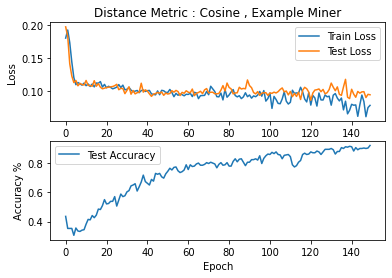

Max Test Acc = 0.9181286549707602


In [8]:
plot_graph(train_loss_cosine , test_loss_cosine , test_acc_cosine , 'Cosine , Example Miner')
print('Max Test Acc = {}' .format(np.max(test_acc_cosine)))

In [9]:
data_test,target_test=get_sub_data_embed(dataset_test , model_cosine , 5)
data_test = np.float32(data_test/(np.max(data_test)-np.min(data_test)))
data_train,target_train=get_sub_data_embed(dataset_train , model_cosine , 5)
data_train = np.float32(data_train/(np.max(data_train)-np.min(data_train)))

  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 25/25 [00:00<00:00, 33.94it/s]


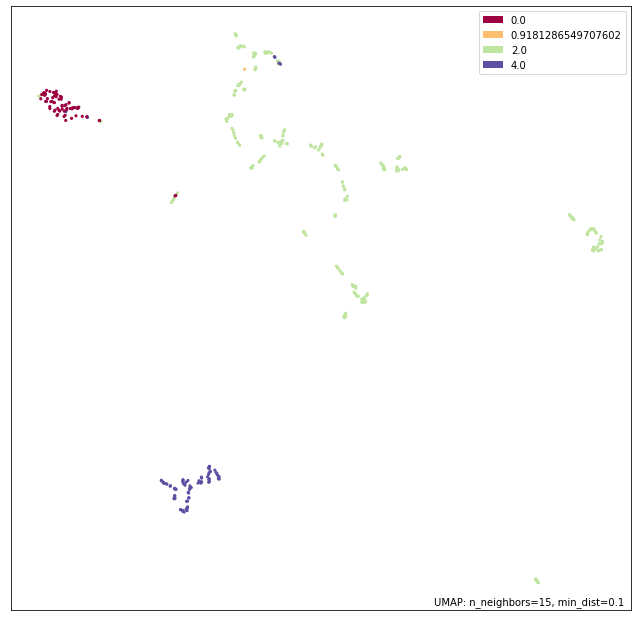

In [10]:
import umap
import umap.plot
mapper = umap.UMAP().fit(data_test)
umap.plot.points(mapper, labels=target_test)

/usr/local/lib/python3.8/dist-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/usr/local/lib/python3.8/dist-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/usr/local/lib/python3.8/dist-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


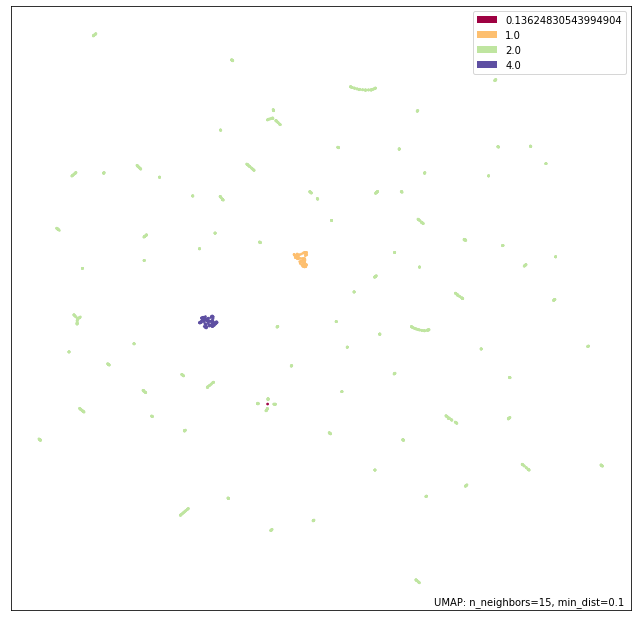

In [11]:
mapper = umap.UMAP().fit(data_train)
umap.plot.points(mapper, labels=target_train)

In [12]:
# KNN :
print("Test Acc without KNN :{} ".format(test_acc_cosine[149]))
KNN_on_embeddings(dataset_train , dataset_test , model_cosine , K=5)

Test Acc without KNN :0.9181286549707602 


  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 11/11 [00:00<00:00, 16.82it/s]


Test Acc :  91.52046783625731


# **Euclidean Distance with Mining**

In [6]:
device='cpu'
num_epochs = 150
model_Lp = Net().to(device)
optimizer = optim.Adam(model_Lp.parameters(), lr=0.01)

### pytorch-metric-learning stuff ###
distance = distances.LpDistance()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard"
)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###

test_acc_Lp=[]
test_loss_Lp=[]
train_loss_Lp=[]
for epoch in range(1, num_epochs + 1):
    print("Epoch : {}".format(epoch))

    train_loss=train(model_Lp, loss_func, mining_func, device, train_loader, optimizer, epoch)
    test_loss , test_acc = test(dataset_train, dataset_test, model_Lp, accuracy_calculator, test_loader , mining_func , loss_func)

    test_loss_Lp.append(test_loss)
    test_acc_Lp.append(test_acc)
    train_loss_Lp.append(train_loss)

    print("******************************************")

Epoch : 1


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train : avg_loss = 0.16948091983795166


100%|██████████| 11/11 [00:00<00:00, 46.29it/s]


Test : avg_loss = 0.3419802784919739
Test : acc = 0.47368421052631576
******************************************
Epoch : 2
Train : avg_loss = 0.13241738080978394


100%|██████████| 11/11 [00:00<00:00, 45.44it/s]


Test : avg_loss = 0.2133355438709259
Test : acc = 0.41228070175438597
******************************************
Epoch : 3
Train : avg_loss = 0.1088072806596756


100%|██████████| 11/11 [00:00<00:00, 46.59it/s]


Test : avg_loss = 0.21551759541034698
Test : acc = 0.35964912280701755
******************************************
Epoch : 4
Train : avg_loss = 0.10778903216123581


100%|██████████| 11/11 [00:00<00:00, 44.89it/s]


Test : avg_loss = 0.20293398201465607
Test : acc = 0.41228070175438597
******************************************
Epoch : 5
Train : avg_loss = 0.10493019223213196


100%|██████████| 11/11 [00:00<00:00, 44.02it/s]


Test : avg_loss = 0.31652185320854187
Test : acc = 0.3654970760233918
******************************************
Epoch : 6
Train : avg_loss = 0.11503686755895615


100%|██████████| 11/11 [00:00<00:00, 45.60it/s]


Test : avg_loss = 0.2138209342956543
Test : acc = 0.39766081871345027
******************************************
Epoch : 7
Train : avg_loss = 0.10671688616275787


100%|██████████| 11/11 [00:00<00:00, 44.75it/s]


Test : avg_loss = 0.21158111095428467
Test : acc = 0.42105263157894735
******************************************
Epoch : 8
Train : avg_loss = 0.10040070861577988


100%|██████████| 11/11 [00:00<00:00, 44.64it/s]


Test : avg_loss = 0.22407576441764832
Test : acc = 0.391812865497076
******************************************
Epoch : 9
Train : avg_loss = 0.107424296438694


100%|██████████| 11/11 [00:00<00:00, 40.53it/s]


Test : avg_loss = 0.20932045578956604
Test : acc = 0.43859649122807015
******************************************
Epoch : 10
Train : avg_loss = 0.10409906506538391


100%|██████████| 11/11 [00:00<00:00, 41.13it/s]


Test : avg_loss = 0.2083820104598999
Test : acc = 0.40058479532163743
******************************************
Epoch : 11
Train : avg_loss = 0.10261644423007965


100%|██████████| 11/11 [00:00<00:00, 41.59it/s]


Test : avg_loss = 0.22171008586883545
Test : acc = 0.35964912280701755
******************************************
Epoch : 12
Train : avg_loss = 0.10501344501972198


100%|██████████| 11/11 [00:00<00:00, 44.81it/s]


Test : avg_loss = 0.2052905559539795
Test : acc = 0.43567251461988304
******************************************
Epoch : 13
Train : avg_loss = 0.10266061872243881


100%|██████████| 11/11 [00:00<00:00, 42.97it/s]


Test : avg_loss = 0.21007853746414185
Test : acc = 0.3713450292397661
******************************************
Epoch : 14
Train : avg_loss = 0.10921119153499603


100%|██████████| 11/11 [00:00<00:00, 41.28it/s]


Test : avg_loss = 0.20831385254859924
Test : acc = 0.40350877192982454
******************************************
Epoch : 15
Train : avg_loss = 0.10029507428407669


100%|██████████| 11/11 [00:00<00:00, 41.73it/s]


Test : avg_loss = 0.20146316289901733
Test : acc = 0.4152046783625731
******************************************
Epoch : 16
Train : avg_loss = 0.10475695133209229


100%|██████████| 11/11 [00:00<00:00, 38.61it/s]


Test : avg_loss = 0.19635385274887085
Test : acc = 0.4619883040935672
******************************************
Epoch : 17
Train : avg_loss = 0.10711847245693207


100%|██████████| 11/11 [00:00<00:00, 38.29it/s]


Test : avg_loss = 0.20306852459907532
Test : acc = 0.48830409356725146
******************************************
Epoch : 18
Train : avg_loss = 0.10628022253513336


100%|██████████| 11/11 [00:00<00:00, 39.34it/s]


Test : avg_loss = 0.202652245759964
Test : acc = 0.4678362573099415
******************************************
Epoch : 19
Train : avg_loss = 0.10276484489440918


100%|██████████| 11/11 [00:00<00:00, 32.33it/s]


Test : avg_loss = 0.20314621925354004
Test : acc = 0.5175438596491229
******************************************
Epoch : 20
Train : avg_loss = 0.10730909556150436


100%|██████████| 11/11 [00:00<00:00, 35.76it/s]


Test : avg_loss = 0.21069872379302979
Test : acc = 0.5233918128654971
******************************************
Epoch : 21
Train : avg_loss = 0.11027741432189941


100%|██████████| 11/11 [00:00<00:00, 39.32it/s]


Test : avg_loss = 0.20073169469833374
Test : acc = 0.5087719298245614
******************************************
Epoch : 22
Train : avg_loss = 0.10449139773845673


100%|██████████| 11/11 [00:00<00:00, 35.57it/s]


Test : avg_loss = 0.20267972350120544
Test : acc = 0.5380116959064327
******************************************
Epoch : 23
Train : avg_loss = 0.10275670886039734


100%|██████████| 11/11 [00:00<00:00, 39.24it/s]


Test : avg_loss = 0.19805210828781128
Test : acc = 0.6052631578947368
******************************************
Epoch : 24
Train : avg_loss = 0.10605496168136597


100%|██████████| 11/11 [00:00<00:00, 41.08it/s]


Test : avg_loss = 0.20333421230316162
Test : acc = 0.5760233918128655
******************************************
Epoch : 25
Train : avg_loss = 0.10831201821565628


100%|██████████| 11/11 [00:00<00:00, 40.30it/s]


Test : avg_loss = 0.1991681158542633
Test : acc = 0.5614035087719298
******************************************
Epoch : 26
Train : avg_loss = 0.09965074807405472


100%|██████████| 11/11 [00:00<00:00, 36.89it/s]


Test : avg_loss = 0.2058044672012329
Test : acc = 0.5467836257309941
******************************************
Epoch : 27
Train : avg_loss = 0.10768484324216843


100%|██████████| 11/11 [00:00<00:00, 39.25it/s]


Test : avg_loss = 0.2047705054283142
Test : acc = 0.6052631578947368
******************************************
Epoch : 28
Train : avg_loss = 0.10815644264221191


100%|██████████| 11/11 [00:00<00:00, 39.73it/s]


Test : avg_loss = 0.19834251701831818
Test : acc = 0.5497076023391813
******************************************
Epoch : 29
Train : avg_loss = 0.09806060791015625


100%|██████████| 11/11 [00:00<00:00, 36.41it/s]


Test : avg_loss = 0.19828423857688904
Test : acc = 0.5467836257309941
******************************************
Epoch : 30
Train : avg_loss = 0.10875368863344193


100%|██████████| 11/11 [00:00<00:00, 33.66it/s]


Test : avg_loss = 0.20057961344718933
Test : acc = 0.6081871345029239
******************************************
Epoch : 31
Train : avg_loss = 0.10490495711565018


100%|██████████| 11/11 [00:00<00:00, 34.54it/s]


Test : avg_loss = 0.2057998776435852
Test : acc = 0.6257309941520468
******************************************
Epoch : 32
Train : avg_loss = 0.09507295489311218


100%|██████████| 11/11 [00:00<00:00, 36.70it/s]


Test : avg_loss = 0.23322202265262604
Test : acc = 0.5760233918128655
******************************************
Epoch : 33
Train : avg_loss = 0.11066345870494843


100%|██████████| 11/11 [00:00<00:00, 36.14it/s]


Test : avg_loss = 0.199598491191864
Test : acc = 0.5964912280701754
******************************************
Epoch : 34
Train : avg_loss = 0.10581472516059875


100%|██████████| 11/11 [00:00<00:00, 18.69it/s]


Test : avg_loss = 0.20250967144966125
Test : acc = 0.5614035087719298
******************************************
Epoch : 35
Train : avg_loss = 0.10973156988620758


100%|██████████| 11/11 [00:00<00:00, 34.75it/s]


Test : avg_loss = 0.21366837620735168
Test : acc = 0.5380116959064327
******************************************
Epoch : 36
Train : avg_loss = 0.1125953271985054


100%|██████████| 11/11 [00:00<00:00, 33.33it/s]


Test : avg_loss = 0.19699394702911377
Test : acc = 0.5526315789473685
******************************************
Epoch : 37
Train : avg_loss = 0.10199373960494995


100%|██████████| 11/11 [00:00<00:00, 33.01it/s]


Test : avg_loss = 0.20480728149414062
Test : acc = 0.5380116959064327
******************************************
Epoch : 38
Train : avg_loss = 0.11813361942768097


100%|██████████| 11/11 [00:00<00:00, 35.39it/s]


Test : avg_loss = 0.20881791412830353
Test : acc = 0.5847953216374269
******************************************
Epoch : 39
Train : avg_loss = 0.10480280220508575


100%|██████████| 11/11 [00:00<00:00, 34.59it/s]


Test : avg_loss = 0.21408262848854065
Test : acc = 0.5380116959064327
******************************************
Epoch : 40
Train : avg_loss = 0.103938028216362


100%|██████████| 11/11 [00:00<00:00, 30.88it/s]


Test : avg_loss = 0.20542341470718384
Test : acc = 0.5701754385964912
******************************************
Epoch : 41
Train : avg_loss = 0.10562492161989212


100%|██████████| 11/11 [00:00<00:00, 31.80it/s]


Test : avg_loss = 0.2209164798259735
Test : acc = 0.5760233918128655
******************************************
Epoch : 42
Train : avg_loss = 0.10918446630239487


100%|██████████| 11/11 [00:00<00:00, 32.31it/s]


Test : avg_loss = 0.2805429697036743
Test : acc = 0.6228070175438597
******************************************
Epoch : 43
Train : avg_loss = 0.10988659411668777


100%|██████████| 11/11 [00:00<00:00, 33.14it/s]


Test : avg_loss = 0.2044581174850464
Test : acc = 0.5614035087719298
******************************************
Epoch : 44
Train : avg_loss = 0.10048459470272064


100%|██████████| 11/11 [00:00<00:00, 34.25it/s]


Test : avg_loss = 0.190759539604187
Test : acc = 0.6286549707602339
******************************************
Epoch : 45
Train : avg_loss = 0.1049177423119545


100%|██████████| 11/11 [00:00<00:00, 32.33it/s]


Test : avg_loss = 0.21911361813545227
Test : acc = 0.6023391812865497
******************************************
Epoch : 46
Train : avg_loss = 0.10247358679771423


100%|██████████| 11/11 [00:00<00:00, 32.57it/s]


Test : avg_loss = 0.19525179266929626
Test : acc = 0.6228070175438597
******************************************
Epoch : 47
Train : avg_loss = 0.1004452034831047


100%|██████████| 11/11 [00:00<00:00, 27.84it/s]


Test : avg_loss = 0.203398197889328
Test : acc = 0.6403508771929824
******************************************
Epoch : 48
Train : avg_loss = 0.09941428899765015


100%|██████████| 11/11 [00:00<00:00, 32.00it/s]


Test : avg_loss = 0.19048190116882324
Test : acc = 0.6374269005847953
******************************************
Epoch : 49
Train : avg_loss = 0.0950421467423439


100%|██████████| 11/11 [00:00<00:00, 30.61it/s]


Test : avg_loss = 0.2126791775226593
Test : acc = 0.631578947368421
******************************************
Epoch : 50
Train : avg_loss = 0.10289406776428223


100%|██████████| 11/11 [00:00<00:00, 30.77it/s]


Test : avg_loss = 0.18969297409057617
Test : acc = 0.6169590643274854
******************************************
Epoch : 51
Train : avg_loss = 0.10240094363689423


100%|██████████| 11/11 [00:00<00:00, 30.31it/s]


Test : avg_loss = 0.20956560969352722
Test : acc = 0.6374269005847953
******************************************
Epoch : 52
Train : avg_loss = 0.1093086376786232


100%|██████████| 11/11 [00:00<00:00, 29.56it/s]


Test : avg_loss = 0.2049224078655243
Test : acc = 0.6403508771929824
******************************************
Epoch : 53
Train : avg_loss = 0.10709884762763977


100%|██████████| 11/11 [00:00<00:00, 29.77it/s]


Test : avg_loss = 0.20659899711608887
Test : acc = 0.6345029239766082
******************************************
Epoch : 54
Train : avg_loss = 0.11058923602104187


100%|██████████| 11/11 [00:00<00:00, 14.98it/s]


Test : avg_loss = 0.21366161108016968
Test : acc = 0.6461988304093568
******************************************
Epoch : 55
Train : avg_loss = 0.10253219306468964


100%|██████████| 11/11 [00:00<00:00, 15.32it/s]


Test : avg_loss = 0.21946240961551666
Test : acc = 0.6695906432748538
******************************************
Epoch : 56
Train : avg_loss = 0.10565701872110367


100%|██████████| 11/11 [00:00<00:00, 13.90it/s]


Test : avg_loss = 0.20643895864486694
Test : acc = 0.6637426900584795
******************************************
Epoch : 57
Train : avg_loss = 0.10503022372722626


100%|██████████| 11/11 [00:00<00:00, 12.61it/s]


Test : avg_loss = 0.20517447590827942
Test : acc = 0.6403508771929824
******************************************
Epoch : 58
Train : avg_loss = 0.09773129224777222


100%|██████████| 11/11 [00:00<00:00, 14.82it/s]


Test : avg_loss = 0.21280646324157715
Test : acc = 0.6608187134502924
******************************************
Epoch : 59
Train : avg_loss = 0.09993225336074829


100%|██████████| 11/11 [00:00<00:00, 24.66it/s]


Test : avg_loss = 0.21882767975330353
Test : acc = 0.6432748538011696
******************************************
Epoch : 60
Train : avg_loss = 0.10391800105571747


100%|██████████| 11/11 [00:00<00:00, 26.43it/s]


Test : avg_loss = 0.20734664797782898
Test : acc = 0.631578947368421
******************************************
Epoch : 61
Train : avg_loss = 0.09954921901226044


100%|██████████| 11/11 [00:00<00:00, 26.32it/s]


Test : avg_loss = 0.20075851678848267
Test : acc = 0.6988304093567251
******************************************
Epoch : 62
Train : avg_loss = 0.09825316071510315


100%|██████████| 11/11 [00:00<00:00, 25.93it/s]


Test : avg_loss = 0.19630983471870422
Test : acc = 0.6228070175438597
******************************************
Epoch : 63
Train : avg_loss = 0.11096321791410446


100%|██████████| 11/11 [00:00<00:00, 25.97it/s]


Test : avg_loss = 0.19988372921943665
Test : acc = 0.6842105263157895
******************************************
Epoch : 64
Train : avg_loss = 0.10533072799444199


100%|██████████| 11/11 [00:00<00:00, 24.31it/s]


Test : avg_loss = 0.19696453213691711
Test : acc = 0.6695906432748538
******************************************
Epoch : 65
Train : avg_loss = 0.10165348649024963


100%|██████████| 11/11 [00:00<00:00, 24.74it/s]


Test : avg_loss = 0.2829952836036682
Test : acc = 0.6432748538011696
******************************************
Epoch : 66
Train : avg_loss = 0.11903925240039825


100%|██████████| 11/11 [00:00<00:00, 26.64it/s]


Test : avg_loss = 0.22407840192317963
Test : acc = 0.7134502923976608
******************************************
Epoch : 67
Train : avg_loss = 0.09876804053783417


100%|██████████| 11/11 [00:00<00:00, 25.68it/s]


Test : avg_loss = 0.18208372592926025
Test : acc = 0.652046783625731
******************************************
Epoch : 68
Train : avg_loss = 0.09479441493749619


100%|██████████| 11/11 [00:00<00:00, 25.69it/s]


Test : avg_loss = 0.19459304213523865
Test : acc = 0.6871345029239766
******************************************
Epoch : 69
Train : avg_loss = 0.100867360830307


100%|██████████| 11/11 [00:00<00:00, 25.94it/s]


Test : avg_loss = 0.19901293516159058
Test : acc = 0.6900584795321637
******************************************
Epoch : 70
Train : avg_loss = 0.09495401382446289


100%|██████████| 11/11 [00:00<00:00, 25.75it/s]


Test : avg_loss = 0.20310455560684204
Test : acc = 0.7134502923976608
******************************************
Epoch : 71
Train : avg_loss = 0.10575881600379944


100%|██████████| 11/11 [00:00<00:00, 24.07it/s]


Test : avg_loss = 0.21204999089241028
Test : acc = 0.6842105263157895
******************************************
Epoch : 72
Train : avg_loss = 0.11031220853328705


100%|██████████| 11/11 [00:00<00:00, 26.06it/s]


Test : avg_loss = 0.20666074752807617
Test : acc = 0.7368421052631579
******************************************
Epoch : 73
Train : avg_loss = 0.09859544783830643


100%|██████████| 11/11 [00:00<00:00, 25.89it/s]


Test : avg_loss = 0.21331435441970825
Test : acc = 0.7514619883040936
******************************************
Epoch : 74
Train : avg_loss = 0.09761914610862732


100%|██████████| 11/11 [00:00<00:00, 17.32it/s]


Test : avg_loss = 0.19955337047576904
Test : acc = 0.7309941520467836
******************************************
Epoch : 75
Train : avg_loss = 0.09591945260763168


100%|██████████| 11/11 [00:00<00:00, 23.28it/s]


Test : avg_loss = 0.19548338651657104
Test : acc = 0.7105263157894737
******************************************
Epoch : 76
Train : avg_loss = 0.09696406126022339


100%|██████████| 11/11 [00:00<00:00, 21.98it/s]


Test : avg_loss = 0.19215133786201477
Test : acc = 0.695906432748538
******************************************
Epoch : 77
Train : avg_loss = 0.09801510721445084


100%|██████████| 11/11 [00:00<00:00, 21.69it/s]


Test : avg_loss = 0.20988008379936218
Test : acc = 0.7076023391812866
******************************************
Epoch : 78
Train : avg_loss = 0.10266835987567902


100%|██████████| 11/11 [00:00<00:00, 21.59it/s]


Test : avg_loss = 0.19023150205612183
Test : acc = 0.6842105263157895
******************************************
Epoch : 79
Train : avg_loss = 0.09526199102401733


100%|██████████| 11/11 [00:00<00:00, 23.42it/s]


Test : avg_loss = 0.1943943202495575
Test : acc = 0.7192982456140351
******************************************
Epoch : 80
Train : avg_loss = 0.09654809534549713


100%|██████████| 11/11 [00:00<00:00, 21.31it/s]


Test : avg_loss = 0.24583888053894043
Test : acc = 0.7076023391812866
******************************************
Epoch : 81
Train : avg_loss = 0.12482138723134995


100%|██████████| 11/11 [00:00<00:00, 21.43it/s]


Test : avg_loss = 0.20883357524871826
Test : acc = 0.6461988304093568
******************************************
Epoch : 82
Train : avg_loss = 0.10892080515623093


100%|██████████| 11/11 [00:00<00:00, 22.79it/s]


Test : avg_loss = 0.19816216826438904
Test : acc = 0.695906432748538
******************************************
Epoch : 83
Train : avg_loss = 0.09920059889554977


100%|██████████| 11/11 [00:00<00:00, 24.37it/s]


Test : avg_loss = 0.19740113615989685
Test : acc = 0.716374269005848
******************************************
Epoch : 84
Train : avg_loss = 0.10012035071849823


100%|██████████| 11/11 [00:00<00:00, 14.33it/s]


Test : avg_loss = 0.2249131202697754
Test : acc = 0.7339181286549707
******************************************
Epoch : 85
Train : avg_loss = 0.11222327500581741


100%|██████████| 11/11 [00:00<00:00, 20.17it/s]


Test : avg_loss = 0.20021915435791016
Test : acc = 0.6900584795321637
******************************************
Epoch : 86
Train : avg_loss = 0.09709262102842331


100%|██████████| 11/11 [00:00<00:00, 20.89it/s]


Test : avg_loss = 0.18898724019527435
Test : acc = 0.7192982456140351
******************************************
Epoch : 87
Train : avg_loss = 0.09689788520336151


100%|██████████| 11/11 [00:00<00:00, 21.34it/s]


Test : avg_loss = 0.19748817384243011
Test : acc = 0.6871345029239766
******************************************
Epoch : 88
Train : avg_loss = 0.11038734763860703


100%|██████████| 11/11 [00:00<00:00, 21.76it/s]


Test : avg_loss = 0.25089898705482483
Test : acc = 0.6988304093567251
******************************************
Epoch : 89
Train : avg_loss = 0.12466351687908173


100%|██████████| 11/11 [00:00<00:00, 20.91it/s]


Test : avg_loss = 0.2290392518043518
Test : acc = 0.7134502923976608
******************************************
Epoch : 90
Train : avg_loss = 0.10865457355976105


100%|██████████| 11/11 [00:00<00:00, 20.91it/s]


Test : avg_loss = 0.23333251476287842
Test : acc = 0.7426900584795322
******************************************
Epoch : 91
Train : avg_loss = 0.10749220103025436


100%|██████████| 11/11 [00:00<00:00, 21.27it/s]


Test : avg_loss = 0.2434263825416565
Test : acc = 0.7134502923976608
******************************************
Epoch : 92
Train : avg_loss = 0.1110682487487793


100%|██████████| 11/11 [00:00<00:00, 21.15it/s]


Test : avg_loss = 0.20852738618850708
Test : acc = 0.7368421052631579
******************************************
Epoch : 93
Train : avg_loss = 0.1036950945854187


100%|██████████| 11/11 [00:00<00:00, 19.91it/s]


Test : avg_loss = 0.19969964027404785
Test : acc = 0.6871345029239766
******************************************
Epoch : 94
Train : avg_loss = 0.09880204498767853


100%|██████████| 11/11 [00:00<00:00, 19.43it/s]


Test : avg_loss = 0.19049669802188873
Test : acc = 0.7105263157894737
******************************************
Epoch : 95
Train : avg_loss = 0.09784691035747528


100%|██████████| 11/11 [00:00<00:00, 17.80it/s]


Test : avg_loss = 0.19938260316848755
Test : acc = 0.6871345029239766
******************************************
Epoch : 96
Train : avg_loss = 0.10349692404270172


100%|██████████| 11/11 [00:00<00:00, 19.70it/s]


Test : avg_loss = 0.20748862624168396
Test : acc = 0.6842105263157895
******************************************
Epoch : 97
Train : avg_loss = 0.10532031953334808


100%|██████████| 11/11 [00:00<00:00, 18.79it/s]


Test : avg_loss = 0.18914438784122467
Test : acc = 0.6929824561403509
******************************************
Epoch : 98
Train : avg_loss = 0.0962594598531723


100%|██████████| 11/11 [00:00<00:00, 22.20it/s]


Test : avg_loss = 0.1979546844959259
Test : acc = 0.7192982456140351
******************************************
Epoch : 99
Train : avg_loss = 0.08858242630958557


100%|██████████| 11/11 [00:00<00:00, 17.68it/s]


Test : avg_loss = 0.2007809579372406
Test : acc = 0.7046783625730995
******************************************
Epoch : 100
Train : avg_loss = 0.09761861711740494


100%|██████████| 11/11 [00:00<00:00, 17.92it/s]


Test : avg_loss = 0.19738510251045227
Test : acc = 0.6988304093567251
******************************************
Epoch : 101
Train : avg_loss = 0.11174505949020386


100%|██████████| 11/11 [00:00<00:00, 20.00it/s]


Test : avg_loss = 0.19801892340183258
Test : acc = 0.7280701754385965
******************************************
Epoch : 102
Train : avg_loss = 0.09466341882944107


100%|██████████| 11/11 [00:00<00:00, 20.42it/s]


Test : avg_loss = 0.22293710708618164
Test : acc = 0.7426900584795322
******************************************
Epoch : 103
Train : avg_loss = 0.10066549479961395


100%|██████████| 11/11 [00:00<00:00, 20.07it/s]


Test : avg_loss = 0.22016778588294983
Test : acc = 0.7251461988304093
******************************************
Epoch : 104
Train : avg_loss = 0.09146873652935028


100%|██████████| 11/11 [00:00<00:00, 21.61it/s]


Test : avg_loss = 0.22121159732341766
Test : acc = 0.7426900584795322
******************************************
Epoch : 105
Train : avg_loss = 0.1040157824754715


100%|██████████| 11/11 [00:00<00:00, 19.63it/s]


Test : avg_loss = 0.195295512676239
Test : acc = 0.7456140350877193
******************************************
Epoch : 106
Train : avg_loss = 0.11128285527229309


100%|██████████| 11/11 [00:00<00:00, 21.11it/s]


Test : avg_loss = 0.21214202046394348
Test : acc = 0.7514619883040936
******************************************
Epoch : 107
Train : avg_loss = 0.100142702460289


100%|██████████| 11/11 [00:00<00:00, 18.13it/s]


Test : avg_loss = 0.22964590787887573
Test : acc = 0.7368421052631579
******************************************
Epoch : 108
Train : avg_loss = 0.1125452071428299


100%|██████████| 11/11 [00:00<00:00, 21.55it/s]


Test : avg_loss = 0.23188063502311707
Test : acc = 0.7777777777777778
******************************************
Epoch : 109
Train : avg_loss = 0.09974577277898788


100%|██████████| 11/11 [00:00<00:00, 20.44it/s]


Test : avg_loss = 0.20373547077178955
Test : acc = 0.7076023391812866
******************************************
Epoch : 110
Train : avg_loss = 0.1045544296503067


100%|██████████| 11/11 [00:00<00:00, 18.76it/s]


Test : avg_loss = 0.20246347784996033
Test : acc = 0.7368421052631579
******************************************
Epoch : 111
Train : avg_loss = 0.09657970070838928


100%|██████████| 11/11 [00:00<00:00, 20.53it/s]


Test : avg_loss = 0.18330228328704834
Test : acc = 0.7368421052631579
******************************************
Epoch : 112
Train : avg_loss = 0.09297871589660645


100%|██████████| 11/11 [00:00<00:00, 19.70it/s]


Test : avg_loss = 0.18687868118286133
Test : acc = 0.7543859649122807
******************************************
Epoch : 113
Train : avg_loss = 0.09942363947629929


100%|██████████| 11/11 [00:00<00:00, 18.84it/s]


Test : avg_loss = 0.19874528050422668
Test : acc = 0.7602339181286549
******************************************
Epoch : 114
Train : avg_loss = 0.10405296087265015


100%|██████████| 11/11 [00:00<00:00, 20.25it/s]


Test : avg_loss = 0.21297979354858398
Test : acc = 0.7426900584795322
******************************************
Epoch : 115
Train : avg_loss = 0.12316606938838959


100%|██████████| 11/11 [00:00<00:00, 19.92it/s]


Test : avg_loss = 0.21710079908370972
Test : acc = 0.7017543859649122
******************************************
Epoch : 116
Train : avg_loss = 0.10450730472803116


100%|██████████| 11/11 [00:00<00:00, 20.61it/s]


Test : avg_loss = 0.2273281216621399
Test : acc = 0.7426900584795322
******************************************
Epoch : 117
Train : avg_loss = 0.11059195548295975


100%|██████████| 11/11 [00:00<00:00, 19.30it/s]


Test : avg_loss = 0.20585224032402039
Test : acc = 0.7222222222222222
******************************************
Epoch : 118
Train : avg_loss = 0.09851432591676712


100%|██████████| 11/11 [00:00<00:00, 20.30it/s]


Test : avg_loss = 0.208653062582016
Test : acc = 0.6783625730994152
******************************************
Epoch : 119
Train : avg_loss = 0.10835288465023041


100%|██████████| 11/11 [00:00<00:00, 19.26it/s]


Test : avg_loss = 0.2269190549850464
Test : acc = 0.6812865497076024
******************************************
Epoch : 120
Train : avg_loss = 0.10757109522819519


100%|██████████| 11/11 [00:00<00:00, 18.46it/s]


Test : avg_loss = 0.2531537711620331
Test : acc = 0.7485380116959064
******************************************
Epoch : 121
Train : avg_loss = 0.11653506755828857


100%|██████████| 11/11 [00:00<00:00, 17.04it/s]


Test : avg_loss = 0.2065056413412094
Test : acc = 0.716374269005848
******************************************
Epoch : 122
Train : avg_loss = 0.09342008829116821


100%|██████████| 11/11 [00:00<00:00, 19.23it/s]


Test : avg_loss = 0.19097641110420227
Test : acc = 0.7192982456140351
******************************************
Epoch : 123
Train : avg_loss = 0.1003098338842392


100%|██████████| 11/11 [00:00<00:00, 18.17it/s]


Test : avg_loss = 0.1984214186668396
Test : acc = 0.7339181286549707
******************************************
Epoch : 124
Train : avg_loss = 0.0997135192155838


100%|██████████| 11/11 [00:00<00:00, 19.20it/s]


Test : avg_loss = 0.2112383246421814
Test : acc = 0.7339181286549707
******************************************
Epoch : 125
Train : avg_loss = 0.10538789629936218


100%|██████████| 11/11 [00:00<00:00, 18.11it/s]


Test : avg_loss = 0.20883522927761078
Test : acc = 0.7602339181286549
******************************************
Epoch : 126
Train : avg_loss = 0.1067807674407959


100%|██████████| 11/11 [00:00<00:00, 16.09it/s]


Test : avg_loss = 0.2186458706855774
Test : acc = 0.7192982456140351
******************************************
Epoch : 127
Train : avg_loss = 0.09316935390233994


100%|██████████| 11/11 [00:00<00:00, 16.99it/s]


Test : avg_loss = 0.1844216287136078
Test : acc = 0.7339181286549707
******************************************
Epoch : 128
Train : avg_loss = 0.09825999289751053


100%|██████████| 11/11 [00:00<00:00, 16.39it/s]


Test : avg_loss = 0.1999352127313614
Test : acc = 0.6929824561403509
******************************************
Epoch : 129
Train : avg_loss = 0.0943036898970604


100%|██████████| 11/11 [00:00<00:00, 17.74it/s]


Test : avg_loss = 0.22869998216629028
Test : acc = 0.6461988304093568
******************************************
Epoch : 130
Train : avg_loss = 0.10203132033348083


100%|██████████| 11/11 [00:00<00:00, 18.34it/s]


Test : avg_loss = 0.2108755111694336
Test : acc = 0.7368421052631579
******************************************
Epoch : 131
Train : avg_loss = 0.10167913138866425


100%|██████████| 11/11 [00:00<00:00, 17.56it/s]


Test : avg_loss = 0.22795629501342773
Test : acc = 0.7309941520467836
******************************************
Epoch : 132
Train : avg_loss = 0.1148439571261406


100%|██████████| 11/11 [00:00<00:00, 19.20it/s]


Test : avg_loss = 0.22035957872867584
Test : acc = 0.6666666666666666
******************************************
Epoch : 133
Train : avg_loss = 0.10550134629011154


100%|██████████| 11/11 [00:00<00:00, 19.11it/s]


Test : avg_loss = 0.2163441777229309
Test : acc = 0.7192982456140351
******************************************
Epoch : 134
Train : avg_loss = 0.11656416207551956


100%|██████████| 11/11 [00:00<00:00, 19.41it/s]


Test : avg_loss = 0.23433153331279755
Test : acc = 0.7339181286549707
******************************************
Epoch : 135
Train : avg_loss = 0.106814444065094


100%|██████████| 11/11 [00:00<00:00, 18.48it/s]


Test : avg_loss = 0.20957045257091522
Test : acc = 0.7456140350877193
******************************************
Epoch : 136
Train : avg_loss = 0.1089208722114563


100%|██████████| 11/11 [00:00<00:00, 17.62it/s]


Test : avg_loss = 0.20898199081420898
Test : acc = 0.7309941520467836
******************************************
Epoch : 137
Train : avg_loss = 0.11916555464267731


100%|██████████| 11/11 [00:00<00:00, 14.78it/s]


Test : avg_loss = 0.23391512036323547
Test : acc = 0.7631578947368421
******************************************
Epoch : 138
Train : avg_loss = 0.09954091906547546


100%|██████████| 11/11 [00:00<00:00, 16.32it/s]


Test : avg_loss = 0.23969219624996185
Test : acc = 0.716374269005848
******************************************
Epoch : 139
Train : avg_loss = 0.10315361618995667


100%|██████████| 11/11 [00:00<00:00, 18.37it/s]


Test : avg_loss = 0.20049989223480225
Test : acc = 0.7426900584795322
******************************************
Epoch : 140
Train : avg_loss = 0.09909714758396149


100%|██████████| 11/11 [00:00<00:00, 17.41it/s]


Test : avg_loss = 0.19574561715126038
Test : acc = 0.716374269005848
******************************************
Epoch : 141
Train : avg_loss = 0.09937941282987595


100%|██████████| 11/11 [00:00<00:00, 16.64it/s]


Test : avg_loss = 0.20359614491462708
Test : acc = 0.7309941520467836
******************************************
Epoch : 142
Train : avg_loss = 0.10501305758953094


100%|██████████| 11/11 [00:00<00:00, 17.24it/s]


Test : avg_loss = 0.21829518675804138
Test : acc = 0.7485380116959064
******************************************
Epoch : 143
Train : avg_loss = 0.09562017768621445


100%|██████████| 11/11 [00:00<00:00, 17.21it/s]


Test : avg_loss = 0.22825360298156738
Test : acc = 0.7251461988304093
******************************************
Epoch : 144
Train : avg_loss = 0.1060098335146904


100%|██████████| 11/11 [00:00<00:00, 17.44it/s]


Test : avg_loss = 0.22751159965991974
Test : acc = 0.7134502923976608
******************************************
Epoch : 145
Train : avg_loss = 0.10737446695566177


100%|██████████| 11/11 [00:00<00:00, 17.96it/s]


Test : avg_loss = 0.22370202839374542
Test : acc = 0.7660818713450293
******************************************
Epoch : 146
Train : avg_loss = 0.11668862402439117


100%|██████████| 11/11 [00:00<00:00, 17.53it/s]


Test : avg_loss = 0.23599140346050262
Test : acc = 0.7397660818713451
******************************************
Epoch : 147
Train : avg_loss = 0.0976857990026474


100%|██████████| 11/11 [00:00<00:00, 15.85it/s]


Test : avg_loss = 0.23163579404354095
Test : acc = 0.7339181286549707
******************************************
Epoch : 148
Train : avg_loss = 0.12637482583522797


100%|██████████| 11/11 [00:00<00:00, 16.95it/s]


Test : avg_loss = 0.20027217268943787
Test : acc = 0.6754385964912281
******************************************
Epoch : 149
Train : avg_loss = 0.10442283004522324


100%|██████████| 11/11 [00:00<00:00, 17.42it/s]


Test : avg_loss = 0.20086967945098877
Test : acc = 0.6695906432748538
******************************************
Epoch : 150
Train : avg_loss = 0.10650447756052017


100%|██████████| 11/11 [00:00<00:00, 18.02it/s]


Test : avg_loss = 0.21060100197792053
Test : acc = 0.7017543859649122
******************************************


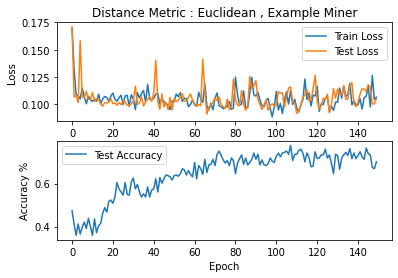

Max Test Acc = 0.7777777777777778


In [7]:
plot_graph(train_loss_Lp , test_loss_Lp , test_acc_Lp , 'Euclidean , Example Miner')
print('Max Test Acc = {}' .format(np.max(test_acc_Lp)))

In [9]:
data_test,target_test=get_sub_data_embed(dataset_test , model_Lp , 5)
data_test = np.float32(data_test/(np.max(data_test)-np.min(data_test)))
data_train,target_train=get_sub_data_embed(dataset_train , model_Lp , 5)
data_train = np.float32(data_train/(np.max(data_train)-np.min(data_train)))

  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 25/25 [00:00<00:00, 30.64it/s]


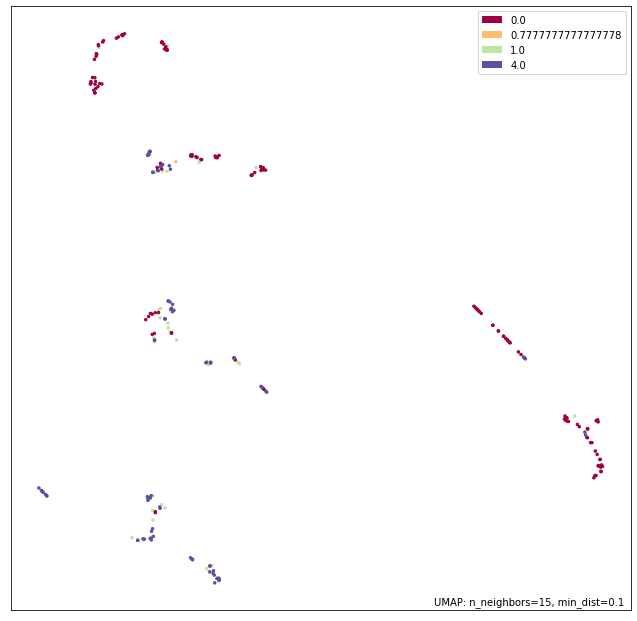

In [10]:
import umap
import umap.plot
mapper = umap.UMAP().fit(data_test)
umap.plot.points(mapper, labels=target_test)

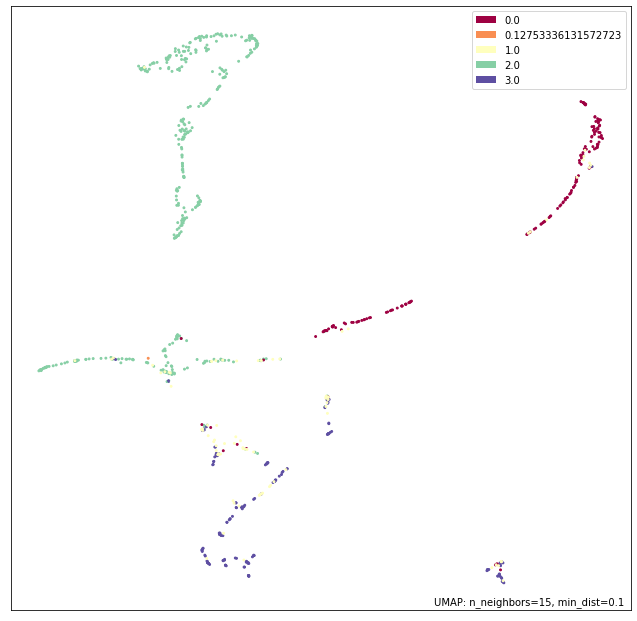

In [11]:
mapper = umap.UMAP().fit(data_train)
umap.plot.points(mapper, labels=target_train)

In [12]:
# KNN :
print("Test Acc without KNN :{} ".format(test_acc_Lp[149]))
KNN_on_embeddings(dataset_train , dataset_test , model_Lp , K=5)

Test Acc without KNN :0.7017543859649122 


  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 11/11 [00:00<00:00, 13.62it/s]


Test Acc :  72.22222222222221
